In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import tensorflow as tf 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns 

In [88]:
warnings.filterwarnings('ignore')

train_dir = "../Human_emotion_dectection/images/train"
test_dir = "../Human_emotion_dectection/images/test"

class_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Neutral',
    5: 'Sad',
    6: 'Surprise'
}

**Tiền xử lý dữ liệu**

In [89]:
# Chuẩn hóa và biến đổi ngẫu nhiên hình ảnh nhằm tăng cường dữ liệu trong tập huấn luyện
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Thay đổi ngẫu nhiên chiều rộng hình ảnh , tối đa 10%
    height_shift_range = 0.1,       # Thay đổi ngẫu nhiên chiều cao hình ảnh, tối đa 10%
    horizontal_flip = True,         # Lật ngang hình ảnh một cách ngẫu nhiên
    rescale = 1./255,               # Chuẩn hóa giá trị pixel về khoảng từ [0,1]
    validation_split = 0.2          # Chia 20% dữ liệu để dùng cho kiểm tra xác thực
)

# Chỉ chuẩn hóa để đánh giá chính xác mô hình
test_datagen = ImageDataGenerator(
    rescale = 1./255,               # Chuẩn hóa giá trị pixel về khoảng từ [0,1]
)

In [90]:
# Sử dụng generator nhằm chia nhỏ dữ liệu để nạp, generator sẽ chỉ nạp 64 ảnh (1 batch) để xử lý và tiếp tục nhận batch tiếp theo thay vì nạp toàn bộ dữ liệu

# Nạp dữ liệu từ thư mục huấn luyện
print(f"Tập huấn luyện (train):")
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Thư mục chứa dữ liệu huấn luyện
    batch_size = 64,                 # Số lượng hình ảnh trong mỗi lô dữ liệu
    target_size = (48, 48),
    color_mode='grayscale',
    class_mode = "categorical",      # Phân loại hình ảnh vào 7 loại cảm xúc
    subset = "training"              # Sử dụng tập con dành cho huấn luyện
)

class_counts_train = Counter(train_generator.classes)
print("Thống kê số lượng hình ảnh trong mỗi lớp trong tập huấn luyện:")
for class_label, count in class_counts_train.items():
    print(f"{class_labels[class_label]}: {count} ảnh")

print(f"\nTập xác thực (validation): (trích ra 20% từ tập train)")
validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=64,
    target_size = (48, 48),
    color_mode='grayscale',
    class_mode="categorical",
    subset="validation"  # Sử dụng tập con dành cho validation
)

class_counts_validataion = Counter(validation_generator.classes)
print("Thống kê số lượng hình ảnh trong mỗi lớp trong tập huấn luyện:")
for class_label, count in class_counts_validataion.items():
    print(f"{class_labels[class_label]}: {count} ảnh")


# Nạp dữ liệu từ thư mục kiểm tra
print(f"\nTập kiểm tra (test):")
test_generator = test_datagen.flow_from_directory(
    directory = test_dir,            # Thư mục chứa dữ liệu kiểm tra
    batch_size = 64,                 # Số lượng hình ảnh trong mỗi lô dữ liệu
    target_size = (48, 48),
    color_mode='grayscale',
    class_mode = "categorical",      # Phân loại hình ảnh vào 7 loại cảm xúc
)

class_counts_test = Counter(test_generator.classes)
print("Thống kê số lượng hình ảnh trong mỗi lớp trong tập kiểm tra:")
for class_label, count in class_counts_test.items():
    print(f"{class_labels[class_label]}: {count} ảnh")

Tập huấn luyện (train):
Found 5066 images belonging to 7 classes.
Thống kê số lượng hình ảnh trong mỗi lớp trong tập huấn luyện:
Angry: 640 ảnh
Disgust: 349 ảnh
Fear: 718 ảnh
Happy: 892 ảnh
Neutral: 984 ảnh
Sad: 706 ảnh
Surprise: 777 ảnh

Tập validation: (trích ra 20% từ tập train)
Found 1264 images belonging to 7 classes.
Thống kê số lượng hình ảnh trong mỗi lớp trong tập huấn luyện:
Angry: 160 ảnh
Disgust: 87 ảnh
Fear: 179 ảnh
Happy: 223 ảnh
Neutral: 245 ảnh
Sad: 176 ảnh
Surprise: 194 ảnh

Tập kiểm tra (test):
Found 1722 images belonging to 7 classes.
Thống kê số lượng hình ảnh trong mỗi lớp trong tập kiểm tra:
Angry: 200 ảnh
Disgust: 111 ảnh
Fear: 400 ảnh
Happy: 200 ảnh
Neutral: 200 ảnh
Sad: 230 ảnh
Surprise: 381 ảnh


**Phân tích và trực quan hóa dữ liệu**

In [91]:
# Xây dựng mô hình CNN
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())

train_features = model.predict(train_generator)
validation_features = model.predict(validation_generator)
test_features = model.predict(test_generator)

80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [94]:
# Phân tích các tham số thống kê của dữ liệu
df_train_features = pd.DataFrame(train_features)
print("Thống kê dữ liệu:")
print(df_train_features.describe())

Thống kê dữ liệu:
              0            1            2            3            4     \
count  5066.000000  5066.000000  5066.000000  5066.000000  5066.000000   
mean      0.000004     0.061844     0.045162     0.000146     0.048140   
std       0.000149     0.025557     0.017938     0.001175     0.019218   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.043954     0.033386     0.000000     0.034522   
50%       0.000000     0.063250     0.046747     0.000000     0.049207   
75%       0.000000     0.080847     0.058454     0.000000     0.062001   
max       0.007605     0.144704     0.100805     0.028177     0.115485   

              5            6       7            8            9     ...  \
count  5066.000000  5066.000000  5066.0  5066.000000  5066.000000  ...   
mean      0.026338     0.011739     0.0     0.000215     0.002979  ...   
std       0.016307     0.010326     0.0     0.001313     0.006536  ...   
min       0.000000 

```python
Giảm chiều dữ liệu
```

In [95]:
#PCA
pca = PCA(n_components = 6)
train_pca = pca.fit_transform(train_features)
test_pca = pca.transform(test_features)

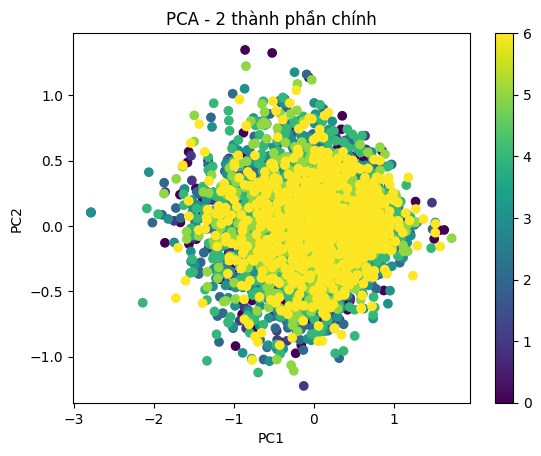

In [96]:
# Hiển thị trực quan bằng PCA
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_generator.classes, cmap='viridis')
plt.title('PCA - 2 thành phần chính')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()